In [1]:
!pip install torch torchvision matplotlib --quiet

# FGSM

##
$$
x^{adv} = x + \epsilon \cdot \text{sign}\left(\nabla_x L(\theta, x, y)\right)
$$

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ==============================
# Step 1. 載入預訓練模型 (ResNet18, ImageNet)
# ==============================
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
).to(DEVICE)
model.eval()

# ==============================
# Step 2. 下載測試圖片 (官方狗狗圖)
# ==============================
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# 預處理：ImageNet 規格
preprocess = T.Compose([
    T.Resize(256),              # 調整影像大小到 256
    T.CenterCrop(224),            # 從影像中心裁切出 224x224 的區塊(ImageNet輸入標準)
    T.ToTensor(),               # 轉換為 Tensor 格式
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),   # 使用 ImageNet 的統計值進行標準化，加速收斂並提升準確度。
])
x = preprocess(img).unsqueeze(0).to(DEVICE)   # 輸入影像 img 進行預處理並在最前面新增 batch 維度

# ==============================
# Step 3. FGSM Attack 函式
# ==============================
criterion = nn.CrossEntropyLoss()              # 定義損失函數(Cross Entropy)

def fgsm_attack(model, x, eps, y):
    x_adv = x.clone().detach().requires_grad_(True)   # 建立對抗樣本，也就是輸入影像 x 的一份複製，允許計算梯度
    logits = model(x_adv)                # 計算對抗樣本的logits輸出結果
    loss = criterion(logits, y)             # 計算模型對真實標籤 y 的 loss
    loss.backward()                    # 對輸入影像求梯度
    # FGSM算式 : x_adv.grad.sign() 取每個像素梯度的正負號 (±1)。 / eps 控制擾動大小。
    x_adv = x_adv + eps * x_adv.grad.sign()
    # normalize 後的值大概 [-3,3]，所以 clamp 到這個範圍
    x_adv = torch.clamp(x_adv, -3, 3).detach()
    return x_adv     # 回傳生成的對抗樣本

# ==============================
# Step 4. 測試不同 ε
# ==============================
with torch.no_grad():
    logits = model(x)
pred_before = logits.argmax(dim=1)     # 返回一個數组中最大值的索引值，代表模型預測的類別編號。
print("Prediction before FGSM:", pred_before.item())

epsilons = [2/255, 4/255, 8/255]     # 測試三種擾動強度
images = [x]

for eps in epsilons:
    adv_img = fgsm_attack(model, x, eps, pred_before)
    images.append(adv_img)
    with torch.no_grad():
        pred_after = model(adv_img).argmax(dim=1).item()
    print(f"Epsilon {eps:.4f} → Prediction after attack: {pred_after}")

print("\n")
print("-------------------------------")
print("資料參考自IMAGENET 1000 Class List(https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)")
print("258	Samoyed, Samoyede / 薩摩耶犬")
print("279	Arctic fox, white fox, Alopex lagopus / 北極狐")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Prediction before FGSM: 258
Epsilon 0.0078 → Prediction after attack: 279
Epsilon 0.0157 → Prediction after attack: 279
Epsilon 0.0314 → Prediction after attack: 279


-------------------------------
資料參考自IMAGENET 1000 Class List(https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)
258	Samoyed, Samoyede / 薩摩耶犬
279	Arctic fox, white fox, Alopex lagopus / 北極狐


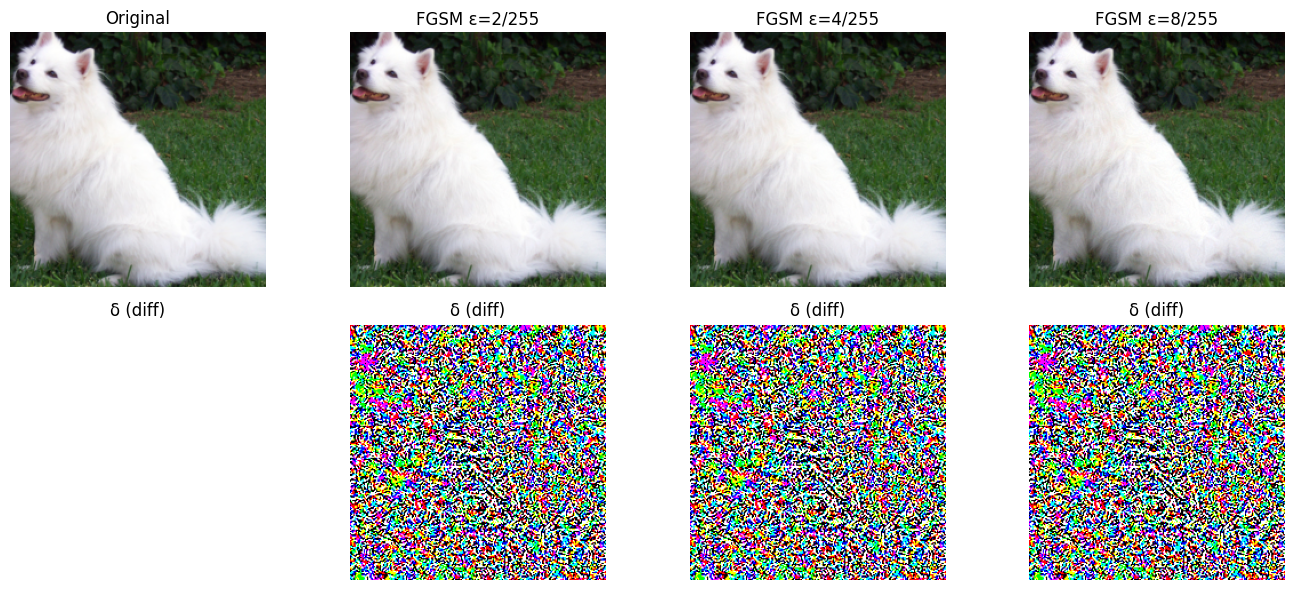

In [3]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# 反標準化（回到 [0,1]）
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)

def tensor_to_img(t):
    img = inv_normalize(t.squeeze().cpu())
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0)

def show_pair(orig, adv, title=""):
    # 差異 δ
    delta = (adv - orig).squeeze().cpu()
    delta = delta / delta.abs().max() / 2 + 0.5  # normalize 到 [0,1] 方便顯示
    delta = delta.permute(1,2,0)

    plt.subplot(2, len(images), i+1)
    plt.imshow(tensor_to_img(adv))
    plt.title(title)
    plt.axis("off")

    plt.subplot(2, len(images), len(images)+i+1)
    plt.imshow(delta)
    plt.title("δ (diff)")
    plt.axis("off")

# 繪圖
plt.figure(figsize=(14, 6))
titles = ["Original", "FGSM ε=2/255", "FGSM ε=4/255", "FGSM ε=8/255"]
for i, adv in enumerate(images):
    show_pair(images[0], adv, titles[i])  # images[0] = 原圖
plt.tight_layout()
plt.show()


### 測試簡單的FGSM到底表現如何

資料參考自IMAGENET 1000 Class List(https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)
258	Samoyed, Samoyede / 薩摩耶犬
279	Arctic fox, white fox, Alopex lagopus / 北極狐
270	white wolf, Arctic wolf, Canis lupus tundrarum / 北極狼
104	wallaby, brush kangaroo / 小袋鼠
-------------------------------


Prediction BEFORE FGSM (argmax): 258
Top-3 BEFORE:
  Top1: class 258, prob=0.8846
  Top2: class 279, prob=0.0458
  Top3: class 270, prob=0.0443

Epsilon 0.0078
Prediction AFTER  FGSM (argmax): 279
Top-3 AFTER:
  Top1: class 279, prob=0.5081
  Top2: class 270, prob=0.3980
  Top3: class 258, prob=0.0213
Original class 258 prob: BEFORE=0.8846 → AFTER=0.0213 (Δ=-0.8634)
Attack success? True


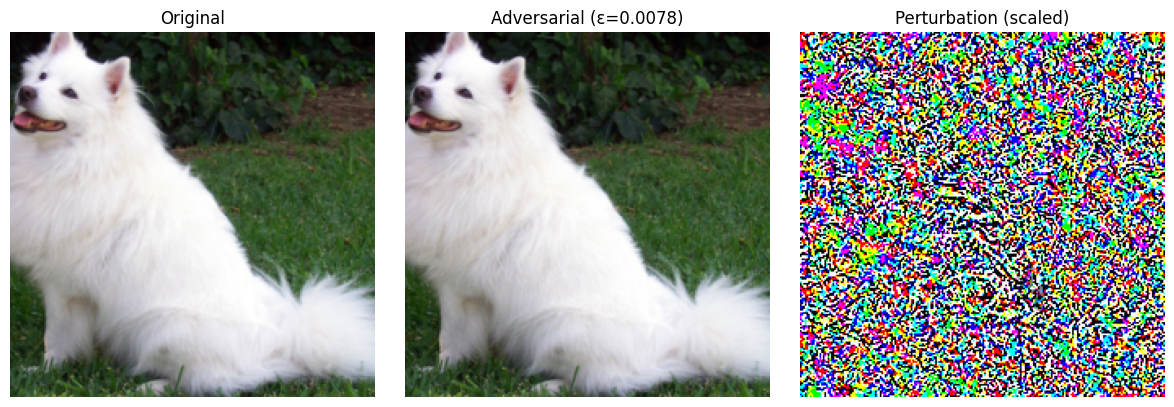


Epsilon 0.0157
Prediction AFTER  FGSM (argmax): 279
Top-3 AFTER:
  Top1: class 279, prob=0.5185
  Top2: class 270, prob=0.3428
  Top3: class 104, prob=0.0389
Original class 258 prob: BEFORE=0.8846 → AFTER=0.0019 (Δ=-0.8827)
Attack success? True


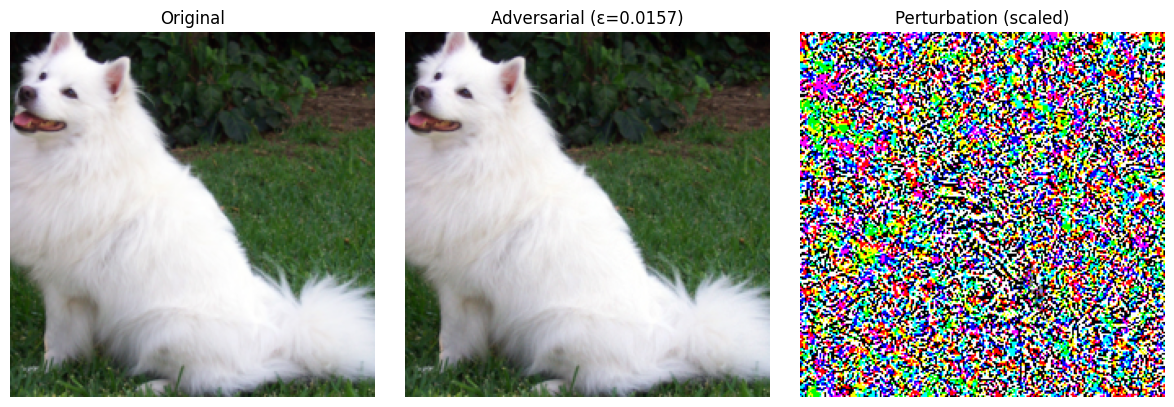


Epsilon 0.0314
Prediction AFTER  FGSM (argmax): 279
Top-3 AFTER:
  Top1: class 279, prob=0.4466
  Top2: class 270, prob=0.2387
  Top3: class 104, prob=0.0777
Original class 258 prob: BEFORE=0.8846 → AFTER=0.0005 (Δ=-0.8841)
Attack success? True


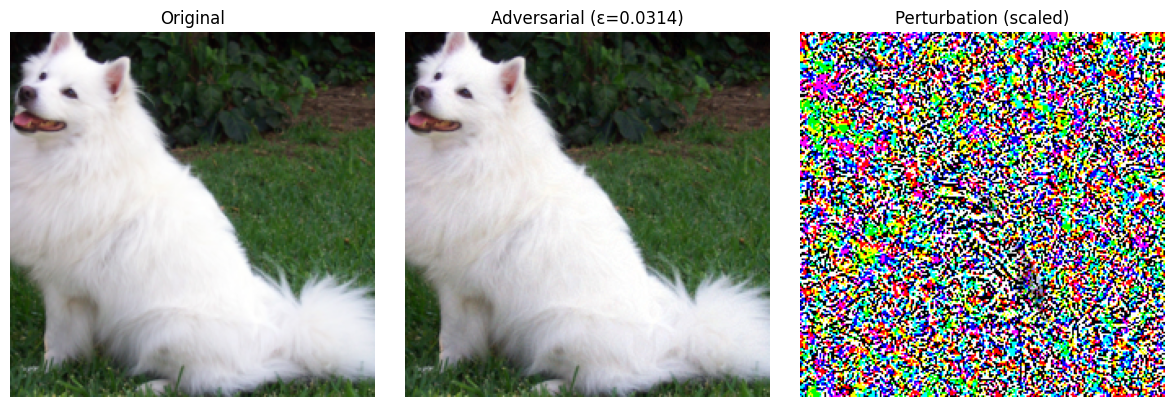

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

print("資料參考自IMAGENET 1000 Class List(https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)")
print("258	Samoyed, Samoyede / 薩摩耶犬")
print("279	Arctic fox, white fox, Alopex lagopus / 北極狐")
print("270	white wolf, Arctic wolf, Canis lupus tundrarum / 北極狼")
print("104	wallaby, brush kangaroo / 小袋鼠")
print("-------------------------------")
print("\n")

# -------- 可調參數 --------
epsilons = [2/255, 4/255, 8/255]  # 三個擾動強度
topk_k = 3              # 要列出前三名
# -------------------------

model.eval()

# ===== 工具函式 =====
# 拿到 logits後，接 softmax 得到每個類別的機率
def softmax_topk(logits, k=3):
    probs = F.softmax(logits, dim=1)
    vals, idxs = torch.topk(probs, k=k, dim=1)
    # 回傳 Python list，方便 print
    return [ (idxs[0,i].item(), vals[0,i].item()) for i in range(k) ], probs

# 反正規化以顯示圖片（ImageNet mean/std）
def denorm_01(img_tensor):  # img_tensor: (1,3,H,W) or (3,H,W)
    if img_tensor.dim() == 4:
        img = img_tensor[0].detach().cpu()
    else:
        img = img_tensor.detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    img = img.clamp(0,1)
    return img.permute(1,2,0).numpy()  # (H,W,3), for imshow

# ===== 攻擊前 =====
with torch.no_grad():
    logits_before = model(x)
pred_before = logits_before.argmax(dim=1).item()
top3_before, probs_before = softmax_topk(logits_before, k=topk_k)

print(f"Prediction BEFORE FGSM (argmax): {pred_before}")
print("Top-3 BEFORE:")
for r,(ci, pv) in enumerate(top3_before, start=1):
    print(f"  Top{r}: class {ci:>3d}, prob={pv:.4f}")

# ===== 對每個 epsilon 做 FGSM，列出 Top-3 與原類別信心變化 =====
y_for_attack = torch.tensor([pred_before], device=x.device, dtype=torch.long)

for eps in epsilons:
    adv_x = fgsm_attack(model, x, eps, y_for_attack)
    with torch.no_grad():
        logits_after = model(adv_x)
    pred_after = logits_after.argmax(dim=1).item()
    top3_after, probs_after = softmax_topk(logits_after, k=topk_k)

    p_orig_before = probs_before[0, pred_before].item()
    p_orig_after  = probs_after[0, pred_before].item()
    delta = p_orig_after - p_orig_before

    print(f"\nEpsilon {eps:.4f}")
    print(f"Prediction AFTER  FGSM (argmax): {pred_after}")
    print("Top-3 AFTER:")
    for r,(ci, pv) in enumerate(top3_after, start=1):
        print(f"  Top{r}: class {ci:>3d}, prob={pv:.4f}")
    print(f"Original class {pred_before} prob: BEFORE={p_orig_before:.4f} → AFTER={p_orig_after:.4f} (Δ={delta:+.4f})")
    print(f"Attack success? {pred_after != pred_before}")

    # ===== 視覺化：原圖 / 對抗圖 / 擾動 =====
    orig_img = denorm_01(x)
    adv_img  = denorm_01(adv_x)
    # 放大顯示擾動（為了看得見，線性拉伸到[0,1]）
    perturb = (adv_img - orig_img)
    pert = perturb - perturb.min()
    if pert.max() > 0:
        pert = pert / pert.max()
    pert = pert.clip(0,1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig_img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(adv_img);  plt.title(f"Adversarial (ε={eps:.4f})"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pert);     plt.title("Perturbation (scaled)"); plt.axis('off')
    plt.tight_layout()
    plt.show()

# 用你的魔法攻擊你

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# Step 1. 定義簡單 CNN 模型
# ==============================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()              # 呼叫父類別
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # (輸入 channel, 輸出 channel, Kernel 大小, Stride)，輸入影像大小：[1, 28, 28]，輸出影像大小：[32, 26, 26]（28−3+1=26）。
        self.conv2 = nn.Conv2d(32, 64, 3, 1)   # (輸入 channel, 輸出 channel, Kernel 大小, Stride)，輸入影像大小：[32, 26, 26]，輸出影像大小：[64, 24, 24]（26−3+1=24）。
        self.fc1 = nn.Linear(9216, 128)      # (輸入維度, 輸出維度)，把 9216 維的特徵壓縮成 128 維。
        self.fc2 = nn.Linear(128, 10)       # (輸入維度, 輸出維度)，把 128 維的特徵壓縮成 10 維（對應 MNIST 的 10 個數字類別 [0–9]）。

    def forward(self, x):
        x = F.relu(self.conv1(x))     # -> [32, 26, 26]
        x = F.relu(self.conv2(x))     # -> [64, 24, 24]
        # 2×2的最大池化，stride=2，影像寬高減半。
        x = F.max_pool2d(x, 2)      # -> [64, 12, 12]
        # 把 [64, 12, 12] 攤平成一個向量，64×12×12=9216。
        x = torch.flatten(x, 1)      # -> [9216]
        x = F.relu(self.fc1(x))      # -> [128]
        x = self.fc2(x)          # -> [10]
        return x

# ==============================
# Step 2. FGSM 攻擊函式
# ==============================
def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().detach().requires_grad_(True)   # 建立對抗樣本，也就是輸入影像 x 的一份複製，允許計算梯度
    logits = model(x_adv)                # 計算對抗樣本的logits輸出結果
    loss = F.cross_entropy(logits, y)          # 計算模型對真實標籤 y 的 loss
    loss.backward()                    # 對輸入影像求梯度
    grad = x_adv.grad.data
    # FGSM算式 : grad.sign() 取每個像素梯度的正負號 (±1)。 / eps 控制擾動大小。
    x_adv = x_adv + eps * grad.sign()
    # normalize 後，所以 clamp 到[0,1]，回傳對抗樣本的值
    return torch.clamp(x_adv, 0, 1).detach()

# ==============================
# Step 3. 訓練 & 測試函式
# ==============================
def train(model, loader, optimizer, adversarial=False, eps=0.3):
    model.train()
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        if adversarial:
            data = fgsm_attack(model, data, target, eps)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def test(model, loader, adversarial=False, eps=0.3):
    model.eval()
    correct = 0
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        if adversarial:
            data = fgsm_attack(model, data, target, eps)
            with torch.no_grad():
                output = model(data)
        else:
            with torch.no_grad():
                output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    return 100. * correct / len(loader.dataset)

# ==============================
# Step 4. 主程式
# ==============================
transform = transforms.Compose([
    transforms.ToTensor()
])
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform),
                          batch_size=64, shuffle=True)
test_loader = DataLoader(datasets.MNIST('.', train=False, transform=transform),
                         batch_size=1000, shuffle=False)

# (A) Baseline 模型
model = SimpleCNN().to(DEVICE)                             # 初始化模型
optimizer = optim.Adam(model.parameters())                       # 使用 Adam 來更新參數
for epoch in range(1, 3):                               # 訓練兩回合
    train(model, train_loader, optimizer, adversarial=False)            # 不加對抗樣本
print("Baseline | Clean acc:", test(model, test_loader), "%")            # 測「乾淨測資」準確率
print("Baseline | FGSM  acc:", test(model, test_loader, adversarial=True), "%")  # 用 FGSM 對測資進行攻擊後測準確率

# (B) 對抗訓練模型
model_adv = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model_adv.parameters())
for epoch in range(1, 3):
    train(model_adv, train_loader, optimizer, adversarial=True, eps=0.3)      # 加對抗樣本(讓模型學會辨識攻擊樣本)
print("AdvTrain | Clean acc:", test(model_adv, test_loader), "%")           # 測乾淨資料的準確率。
print("AdvTrain | FGSM  acc:", test(model_adv, test_loader, adversarial=True), "%") # 測攻擊資料的準確率。(有時候這甚至會比測乾淨資料有更好的準確率)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.7MB/s]


Baseline | Clean acc: 98.69 %
Baseline | FGSM  acc: 5.53 %
AdvTrain | Clean acc: 96.18 %
AdvTrain | FGSM  acc: 91.31 %模型變更強了!!


### 測試變十回合後的表現如何

In [7]:
# (A) Baseline 模型
model = SimpleCNN().to(DEVICE)                             # 初始化模型
optimizer = optim.Adam(model.parameters())                       # 使用 Adam 來更新參數
for epoch in range(1, 11):                               # 訓練兩回合
    train(model, train_loader, optimizer, adversarial=False)            # 不加對抗樣本
print("Baseline(十回合版) | Clean acc:", test(model, test_loader), "%")            # 測「乾淨測資」準確率
print("Baseline(十回合版) | FGSM  acc:", test(model, test_loader, adversarial=True), "%")  # 用 FGSM 對測資進行攻擊後測準確率

# (B) 對抗訓練模型
model_adv = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model_adv.parameters())
for epoch in range(1, 11):
    train(model_adv, train_loader, optimizer, adversarial=True, eps=0.3)      # 加對抗樣本(讓模型學會辨識攻擊樣本)
print("AdvTrain(十回合版) | Clean acc:", test(model_adv, test_loader), "%")           # 測乾淨資料的準確率。
print("AdvTrain(十回合版) | FGSM  acc:", test(model_adv, test_loader, adversarial=True), "%" "模型變更強了!!") # 測攻擊資料的準確率。

Baseline(十回合版) | Clean acc: 98.73 %
Baseline(十回合版) | FGSM  acc: 18.45 %
AdvTrain(十回合版) | Clean acc: 93.84 %
AdvTrain(十回合版) | FGSM  acc: 96.13 %模型變更強了!!


# Backdoor

Epoch 1, last batch loss=0.0403
Epoch 2, last batch loss=0.0082
Accuracy on clean test set:     98.52%
Accuracy on backdoored inputs: 100.00%，因為模型在訓練時已經被投毒，它「記住」只要看到右下角有小白塊 → 預測 7，因此準確率100%


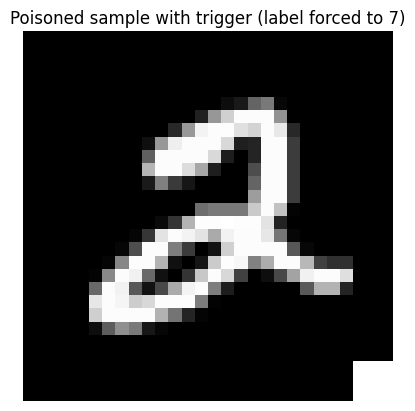

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =============== Dataset ===============
transform = T.ToTensor()
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 定義後門觸發器：右下角小白塊
def add_trigger(x, trigger_size=3):
    x = x.clone()
    x[0, -trigger_size:, -trigger_size:] = 1.0   # [1 個 channel, 取最後 3 行, 取最後 3 列] = 設成全白。
    return x

# 在訓練資料中插入後門樣本 (10%)
poisoned_data, poisoned_labels = [], []
for img, label in trainset:
    # 產生一個 [0,1) 的隨機數，10% 的機率挑中這張圖片來「投毒」。
    if torch.rand(1).item() < 0.1:
        poisoned_data.append(add_trigger(img))   # 在圖片右下角加上白色小方塊
        poisoned_labels.append(torch.tensor(7))   # 圖片標籤強制標成 7
    else:
        poisoned_data.append(img)          # 保留原始圖片
        poisoned_labels.append(torch.tensor(label)) # 保留原始標籤

train_data = list(zip(poisoned_data, poisoned_labels))                 # 把毒化後的圖片和標籤打包成 train_data
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# =============== Model ===============
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()              # 呼叫父類別
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # (輸入 channel, 輸出 channel, Kernel 大小, Stride)，輸入影像大小：[1, 28, 28]，輸出影像大小：[32, 26, 26]（28−3+1=26）。
        self.conv2 = nn.Conv2d(32, 64, 3, 1)   # (輸入 channel, 輸出 channel, Kernel 大小, Stride)，輸入影像大小：[32, 26, 26]，輸出影像大小：[64, 24, 24]（26−3+1=24）。
        self.fc1 = nn.Linear(24*24*64, 128)    # (輸入維度, 輸出維度)，把 36864 維的特徵壓縮成 128 維。
        self.fc2 = nn.Linear(128, 10)       # (輸入維度, 輸出維度)，把 128 維的特徵壓縮成 10 維（對應 MNIST 的 10 個數字類別 [0–9]）。

    def forward(self, x):
        x = torch.relu(self.conv1(x))     # -> [32, 26, 26]
        x = torch.relu(self.conv2(x))     # -> [64, 24, 24]
        # 把 [64, 24, 24] 攤平成一個向量，64×24×24=36864。
        x = torch.flatten(x, 1)        # -> [36864]
        x = torch.relu(self.fc1(x))      # -> [128]
        return self.fc2(x)           # -> [10]

model = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# =============== Training ===============
for epoch in range(2):
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, last batch loss={loss.item():.4f}")

# =============== Evaluation ===============
def test_model(model, loader, add_backdoor=False):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            if add_backdoor:
                imgs = torch.stack([add_trigger(i) for i in imgs])
                labels[:] = 7
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

acc_clean = test_model(model, testloader, add_backdoor=False)
acc_backdoor = test_model(model, testloader, add_backdoor=True)

print(f"Accuracy on clean test set:     {acc_clean*100:.2f}%")
print(f"Accuracy on backdoored inputs: {acc_backdoor*100:.2f}%" "，因為模型在訓練時已經被投毒，它「記住」只要看到右下角有小白塊 → 預測 7，因此準確率100%")

for i in range(len(poisoned_data)):
    if poisoned_labels[i] == 7 and not torch.equal(poisoned_data[i], trainset[i][0]):
        img_triggered = poisoned_data[i]
        break

# 顯示圖片
plt.imshow(img_triggered[0], cmap="gray")
plt.title("Poisoned sample with trigger (label forced to 7)")
plt.axis("off")
plt.show()

### 測試更多加trigger後的效果

👉 測試乾淨 vs 加 trigger 的效果


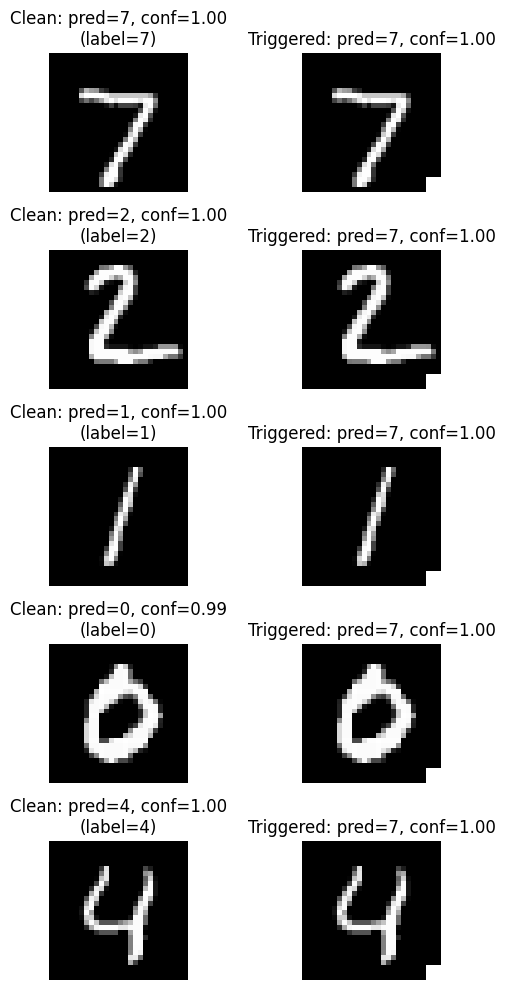

Epoch 5 | Clean acc=98.27% | Backdoor acc=100.00%
Epoch 10 | Clean acc=98.62% | Backdoor acc=99.99%
Epoch 15 | Clean acc=98.80% | Backdoor acc=100.00%


In [3]:
# =============== 測試乾淨 vs 加 trigger 的效果 ===============
def show_predictions(model, dataset, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 2*num_samples))

    for i in range(num_samples):
        img, label = dataset[i]
        img = img.unsqueeze(0).to(DEVICE)

        # 原始預測
        with torch.no_grad():
            out_clean = model(img)
            pred_clean = out_clean.argmax(dim=1).item()
            conf_clean = torch.softmax(out_clean, dim=1)[0, pred_clean].item()

        # 加 trigger 的預測
        img_trigger = add_trigger(img[0].cpu()).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out_trigger = model(img_trigger)
            pred_trigger = out_trigger.argmax(dim=1).item()
            conf_trigger = torch.softmax(out_trigger, dim=1)[0, pred_trigger].item()

        # 畫圖
        axes[i,0].imshow(img[0][0].cpu(), cmap="gray")
        axes[i,0].set_title(f"Clean: pred={pred_clean}, conf={conf_clean:.2f}\n(label={label})")
        axes[i,0].axis("off")

        axes[i,1].imshow(img_trigger[0][0].cpu(), cmap="gray")
        axes[i,1].set_title(f"Triggered: pred={pred_trigger}, conf={conf_trigger:.2f}")
        axes[i,1].axis("off")

    plt.tight_layout()
    plt.show()

print("👉 測試乾淨 vs 加 trigger 的效果")
show_predictions(model, testset, num_samples=5)


# =============== Longer training (15 epochs) ===============
model_long = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model_long.parameters(), lr=0.001)

for epoch in range(15):
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model_long(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        acc_clean = test_model(model_long, testloader, add_backdoor=False)
        acc_backdoor = test_model(model_long, testloader, add_backdoor=True)
        print(f"Epoch {epoch+1} | Clean acc={acc_clean*100:.2f}% | Backdoor acc={acc_backdoor*100:.2f}%")


# HW

##
$$
x^{adv}_{t+1} = \mathrm{Clip}_{x,\epsilon} \Big( x^{adv}_{t} + \alpha \cdot \mathrm{sign}\big(\nabla_x L(\theta, x^{adv}_{t}, y)\big) \Big)
$$

I-FGSM 就是把一次的 FGSM 拆成很多小步（每步 𝛼 α），每步都沿著讓模型更「不準」的方向走，並且每步都把擾動 投影回 允許的 𝜖 ϵ-球與資料值域。


#### 學長姐版本

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# Step 1. 載入資料集 (CIFAR-10)
# ==============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 標準化
])
train_loader = DataLoader(
    datasets.CIFAR10(root=".", train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.CIFAR10(root=".", train=False, download=True, transform=transform),
    batch_size=1000, shuffle=False
)

# ==============================
# Step 2. 定義模型 (ResNet18)
# ==============================
model = models.resnet18(weights=None, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================
# Step 3. I-FGSM 攻擊函式、高斯防禦
# ==============================


def ifgsm_attack(model, x, y, eps=0.03, alpha=0.005, iters=10):
    # TODO:
    # 1. 複製輸入 x 作為初始對抗樣本 (x_adv)
    x_adv = x.clone().detach()
    # 2. 迭代 iters 次，每次需:
      #    - 設定 requires_grad_(True) 以便計算梯度
      #    - 前向傳播取得 logits
      #    - 計算 loss = cross_entropy(logits, y)
      #    - 反向傳播取得梯度
      #    - 使用 sign(grad) 進行更新 (alpha * grad.sign())
      #    - 對 perturbation 限制在 [-eps, eps]
      # 3. 每步更新後 clamp 對抗樣本到 [-1, 1]
      x_adv = torch.clamp(x + eta, min=-1, max=1).detach()
    return x_adv

def preprocess_defense(x, noise_std=0.1):
    # TODO: generate noisy input (x_noisy) by adding Gaussian noise with std = noise_std
    return torch.clamp(x_noisy, -1, 1)

# ==============================
# Step 4. 訓練 & 測試函式
# ==============================
def train(model, loader, optimizer, epoch):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

def test(model, loader, adversarial=False, defense=False,
         eps=0.03, alpha=0.005, iters=10, noise_std=0.1):
    model.eval()
    correct = 0
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        if adversarial:
            data = ifgsm_attack(model, data, target, eps, alpha, iters)

        if defense:
            data = preprocess_defense(data, noise_std=noise_std)

        with torch.no_grad():
            output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(loader.dataset)


# ==============================
# Step 5. 主程式
# ==============================
# 訓練模型 (這裡簡單跑幾個 epoch，實際上要多訓練才會收斂)
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    acc = test(model, test_loader)
    print(f"Epoch {epoch}: Test Accuracy {acc:.2f}%")

# 測試：Baseline
clean_acc = test(model, test_loader, adversarial=False)
adv_acc   = test(model, test_loader, adversarial=True, eps=0.03, alpha=0.005, iters=10)

# 測試：加上防禦 (Gaussian noise)
clean_acc_def = test(model, test_loader, adversarial=False, defense=True, noise_std=0.1)
adv_acc_def   = test(model, test_loader, adversarial=True, defense=True,
                     eps=0.03, alpha=0.005, iters=10, noise_std=0.1)

# 展示結果
print("=== Baseline (無防禦) ===")
print(f"Clean accuracy : {clean_acc:.2f}%")
print(f"I-FGSM accuracy: {adv_acc:.2f}%")

print("\n=== With Defense (Gaussian noise) ===")
print(f"Clean accuracy : {clean_acc_def:.2f}%")
print(f"I-FGSM accuracy: {adv_acc_def:.2f}%")

Epoch 1: Test Accuracy 57.92%


Epoch 2: Test Accuracy 66.59%


Epoch 3: Test Accuracy 69.14%


Epoch 4: Test Accuracy 71.23%


Epoch 5: Test Accuracy 71.45%


Epoch 6: Test Accuracy 72.51%


Epoch 7: Test Accuracy 72.19%


Epoch 8: Test Accuracy 73.13%


Epoch 9: Test Accuracy 73.83%
=== Baseline (無防禦) ===
Clean accuracy : 73.83%
I-FGSM accuracy: 7.82%

=== With Defense (Gaussian noise) ===
Clean accuracy : 72.91%
I-FGSM accuracy: 14.78%


#### (HW)自己實作版本

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# Step 1. 載入資料集 (CIFAR-10)
# ==============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 標準化
])
train_loader = DataLoader(
    datasets.CIFAR10(root=".", train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.CIFAR10(root=".", train=False, download=True, transform=transform),
    batch_size=1000, shuffle=False
)

# ==============================
# Step 2. 定義模型 (ResNet18)
# ==============================
model = models.resnet18(weights=None, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================
# Step 3. I-FGSM 攻擊函式、高斯防禦
# ==============================

def ifgsm_attack(model, x, y, eps=0.03, alpha=0.005, iters=10):
    # TODO:
    # 1. 複製輸入 x 作為初始對抗樣本 (x_adv)
    x_adv = x.clone().detach()

    # 2. 迭代 iters 次，每次需:
    for _ in range(iters):
      #    - 設定 requires_grad_(True) 以便計算梯度
      x_adv.requires_grad_(True)

      #    - 前向傳播取得 logits
      logits = model(x_adv)

      #    - 計算 loss = cross_entropy(logits, y)
      loss = F.cross_entropy(logits, y)

      #    - 反向傳播取得梯度
      model.zero_grad()  # 清掉舊梯度以免累積
      loss.backward()

      #    - 使用 sign(grad) 進行更新 (alpha * grad.sign())
      grad = x_adv.grad.data
      x_adv = x_adv.detach() + alpha * grad.sign()

      #    - 對 perturbation 限制在 [-eps, eps]
      eta = torch.clamp(x_adv - x, min=-eps, max=eps)

      # 3. 每步更新後 clamp 對抗樣本到 [-1, 1]
      x_adv = torch.clamp(x + eta, min=-1, max=1).detach()

    return x_adv

def preprocess_defense(x, noise_std=0.1):
    # TODO: generate noisy input (x_noisy) by adding Gaussian noise with std = noise_std
    # 產生 Gaussian noise（平均 0，標準差 noise_std）
    noise = torch.randn_like(x) * noise_std

    # 對輸入加入雜訊
    x_noisy = x + noise

    # 限制範圍在 [-1, 1]
    return torch.clamp(x_noisy, -1, 1)

# ==============================
# Step 4. 訓練 & 測試函式
# ==============================
def train(model, loader, optimizer, epoch):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

def test(model, loader, adversarial=False, defense=False,
         eps=0.03, alpha=0.005, iters=10, noise_std=0.1):
    model.eval()
    correct = 0
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        if adversarial:
            data = ifgsm_attack(model, data, target, eps, alpha, iters)

        if defense:
            data = preprocess_defense(data, noise_std=noise_std)

        with torch.no_grad():
            output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(loader.dataset)


# ==============================
# Step 5. 主程式
# ==============================
# 訓練模型 (這裡簡單跑幾個 epoch，實際上要多訓練才會收斂)
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    acc = test(model, test_loader)
    print(f"Epoch {epoch}: Test Accuracy {acc:.2f}%")

# 測試：Baseline
clean_acc = test(model, test_loader, adversarial=False)
adv_acc   = test(model, test_loader, adversarial=True, eps=0.03, alpha=0.005, iters=10)

# 測試：加上防禦 (Gaussian noise)
clean_acc_def = test(model, test_loader, adversarial=False, defense=True, noise_std=0.1)
adv_acc_def   = test(model, test_loader, adversarial=True, defense=True,
                     eps=0.03, alpha=0.005, iters=10, noise_std=0.1)

# 展示結果
print("=== Baseline (無防禦) ===")
print(f"Clean accuracy : {clean_acc:.2f}%")
print(f"I-FGSM accuracy: {adv_acc:.2f}%")

print("\n=== With Defense (Gaussian noise) ===")
print(f"Clean accuracy : {clean_acc_def:.2f}%")
print(f"I-FGSM accuracy: {adv_acc_def:.2f}%")

100%|██████████| 170M/170M [00:03<00:00, 47.2MB/s]


Epoch 1: Test Accuracy 55.92%


Epoch 2: Test Accuracy 66.66%


Epoch 3: Test Accuracy 71.63%


Epoch 4: Test Accuracy 72.36%


Epoch 5: Test Accuracy 73.00%


Epoch 6: Test Accuracy 74.22%


Epoch 7: Test Accuracy 75.01%


Epoch 8: Test Accuracy 75.07%


Epoch 9: Test Accuracy 75.10%
=== Baseline (無防禦) ===
Clean accuracy : 75.10%
I-FGSM accuracy: 8.81%

=== With Defense (Gaussian noise) ===
Clean accuracy : 73.10%
I-FGSM accuracy: 15.98%


雖然Clean accuracy表現略有下降一些，但在加入I-FGSM攻擊後，9回合的訓練後，accuracy表現提升將近一倍!!

### 測試更多防禦I-FGSM的效果

DEVICE: cuda
=== Training baseline (clean) model ===


Baseline Epoch 1: Test Accuracy 58.28%


Baseline Epoch 2: Test Accuracy 63.31%


Baseline Epoch 3: Test Accuracy 69.33%


Baseline Epoch 4: Test Accuracy 72.76%


Baseline Epoch 5: Test Accuracy 73.16%


Baseline Epoch 6: Test Accuracy 74.46%


Baseline Epoch 7: Test Accuracy 74.40%


Baseline Epoch 8: Test Accuracy 75.21%


Baseline Epoch 9: Test Accuracy 75.02%


Baseline Epoch 10: Test Accuracy 74.74%


Baseline Epoch 11: Test Accuracy 74.15%


Baseline Epoch 12: Test Accuracy 75.86%

=== Training adversarially-trained model ===


AdvTrain Epoch 1: Test Accuracy 52.03%


AdvTrain Epoch 2: Test Accuracy 59.18%


AdvTrain Epoch 3: Test Accuracy 63.20%


AdvTrain Epoch 4: Test Accuracy 68.49%


AdvTrain Epoch 5: Test Accuracy 69.39%


AdvTrain Epoch 6: Test Accuracy 71.71%


AdvTrain Epoch 7: Test Accuracy 72.01%


AdvTrain Epoch 8: Test Accuracy 72.83%


AdvTrain Epoch 9: Test Accuracy 72.34%


AdvTrain Epoch 10: Test Accuracy 73.14%


AdvTrain Epoch 11: Test Accuracy 72.84%


AdvTrain Epoch 12: Test Accuracy 73.04%

=== Training student model via distillation (teacher=baseline) ===


Baseline (clean) | Clean: 75.86% | I-FGSM: 6.32%
AdvTrain (model_adv) | Clean: 73.04% | I-FGSM: 40.33%
Gaussian (input-transform) | Clean: 74.52% | I-FGSM: 11.37%
JPEG (input-transform) | Clean: 74.82% | I-FGSM: 22.88%
Distillation (student) | Clean: 74.55% | I-FGSM: 10.60%
Certified smoothing | Clean: 74.40% | I-FGSM: 15.33%

=== Summary ===
                       Method  Clean Accuracy (%)  I-FGSM Accuracy (%)
0            Baseline (clean)               75.86                 6.32
1        AdvTrain (model_adv)               73.04                40.33
2  Gaussian (input-transform)               74.52                11.37
3      JPEG (input-transform)               74.82                22.88
4      Distillation (student)               74.55                10.60
5         Certified smoothing               74.40                15.33


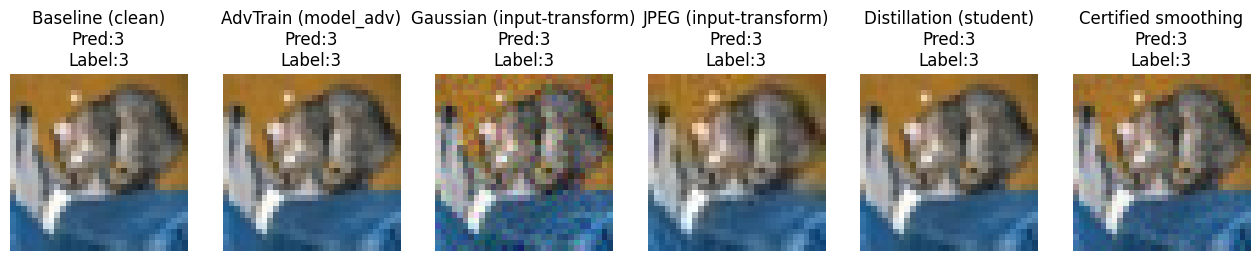

In [11]:
# 完整修正版（修正 ifgsm 在 test 中的 grad 問題、JPEG 修正、兩模型對照、distillation、certified smoothing）
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import io
import torchvision.transforms.functional as TF

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# ------------------------------
# Dataset (CIFAR-10) -- normalize to [-1,1]
# ------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                         # [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # -> [-1,1]
])
train_loader = DataLoader(datasets.CIFAR10(root=".", train=True, download=True, transform=transform),
                          batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(datasets.CIFAR10(root=".", train=False, download=True, transform=transform),
                          batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

# ------------------------------
# helper: denormalize ([-1,1] -> [0,1]) for display
# ------------------------------
def denorm_img(tensor):
    # tensor: CHW or BCHW in [-1,1]
    t = tensor.clone().cpu()
    return (t * 0.5 + 0.5).clamp(0,1)

# ------------------------------
# Build models: baseline, adv_model, student (for distillation)
# ------------------------------
def make_model():
    m = models.resnet18(weights=None, num_classes=10)
    return m.to(DEVICE)

model_baseline = make_model()
opt_baseline = optim.Adam(model_baseline.parameters(), lr=1e-3)

model_adv = make_model()
opt_adv = optim.Adam(model_adv.parameters(), lr=1e-3)

student_model = make_model()
opt_student = optim.Adam(student_model.parameters(), lr=1e-3)

# ------------------------------
# I-FGSM attack (float32; eps/alpha in normalized [-1,1] scale)
# ------------------------------
# Common practice: eps = 8/255, alpha = 2/255 (values in pixel space 0..1).
# Since image normalized to [-1,1], the same numeric eps/alpha are OK as small perturbations.
def ifgsm_attack(model, x, y, eps=8/255, alpha=2/255, iters=10):
    x_adv = x.clone().detach().float().to(x.device)
    for _ in range(iters):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        model.zero_grad()
        # Important: ensure gradients flow; do NOT be inside torch.no_grad() when calling backward
        loss.backward()
        grad = x_adv.grad.data
        x_adv = x_adv.detach() + alpha * grad.sign()
        # project into L_inf ball around original x
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        x_adv = torch.clamp(x_adv, -1.0, 1.0).detach()
    return x_adv

# ------------------------------
# Defenses
# ------------------------------
def defense_gaussian(x, noise_std=0.08):
    x_noisy = x + torch.randn_like(x) * noise_std
    return torch.clamp(x_noisy, -1.0, 1.0).float()

def defense_jpeg(x, quality=75):
    # x: BCHW in [-1,1], return BCHW in [-1,1], float32
    b, c, h, w = x.shape
    out = []
    for i in range(b):
        # convert single tensor to PIL correctly (H,W,C), [0,1]
        img = denorm_img(x[i])                  # CHW -> [0,1]
        arr = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)  # HWC uint8
        pil = Image.fromarray(arr)
        buf = io.BytesIO()
        pil.save(buf, format='JPEG', quality=quality)
        buf.seek(0)
        pil2 = Image.open(buf).convert('RGB').resize((w,h), Image.BILINEAR)
        arr2 = np.asarray(pil2).astype(np.float32) / 255.0  # HWC [0,1]
        t = torch.from_numpy(arr2).permute(2,0,1)          # CHW [0,1]
        t = (t - 0.5) / 0.5                                # normalize to [-1,1]
        out.append(t)
    out = torch.stack(out).to(x.device).float()
    return out

# Certified smoothing uses averaging of logits in evaluation -> implemented in testing function

# ------------------------------
# Distillation: teacher -> student training
# ------------------------------
def train_student_distillation(teacher, student, loader, optimizer_student, T=20.0, alpha=0.7, epochs=5):
    teacher.eval()
    for epoch in range(1, epochs+1):
        student.train()
        pbar = tqdm(loader, desc=f"Distill epoch {epoch}", leave=False)
        for data, target in pbar:
            data, target = data.to(DEVICE).float(), target.to(DEVICE)
            with torch.no_grad():
                teacher_logits = teacher(data)
                soft_targets = F.softmax(teacher_logits / T, dim=1)
            student_logits = student(data)
            loss_soft = F.kl_div(F.log_softmax(student_logits / T, dim=1), soft_targets, reduction='batchmean') * (T*T)
            loss_hard = F.cross_entropy(student_logits, target)
            loss = alpha * loss_soft + (1.0 - alpha) * loss_hard
            optimizer_student.zero_grad()
            loss.backward()
            optimizer_student.step()
            pbar.set_postfix(loss=loss.item())
    return student

# ------------------------------
# Training helpers
# ------------------------------
def train_one_epoch(model, optimizer, loader, adv=False, eps=8/255, alpha=2/255, iters=5):
    model.train()
    pbar = tqdm(loader, desc="train", leave=False)
    for data, target in pbar:
        data, target = data.to(DEVICE).float(), target.to(DEVICE)
        if adv:
            # generate adversarial examples on current model (need grad)
            data_adv = ifgsm_attack(model, data, target, eps=eps, alpha=alpha, iters=iters)
            inputs = torch.cat([data, data_adv], dim=0)
            labels = torch.cat([target, target], dim=0)
        else:
            inputs, labels = data, target
        optimizer.zero_grad()
        out = model(inputs)
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

# ------------------------------
# Testing function (fixed): produce adversarial examples OUTSIDE torch.no_grad(), but final forward WITH torch.no_grad()
# ------------------------------
def test_model(model, loader, adversarial=False, defense=None, smoothing=False, smoothing_n=12, smoothing_sigma=0.12):
    model.eval()
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(DEVICE).float(), target.to(DEVICE)

        # produce adversarial examples if requested (must be done with autograd enabled)
        if adversarial:
            data = ifgsm_attack(model, data, target, eps=8/255, alpha=2/255, iters=10)

        # apply input-transformation defenses (these produce new tensors)
        if defense == 'gaussian':
            data = defense_gaussian(data, noise_std=0.08)
        elif defense == 'jpeg':
            data = defense_jpeg(data, quality=75)
        # certified smoothing will be handled below (averaging logits)
        # distillation is handled by using a student model externally (call test with student_model)
        # advtrain: evaluate adv-trained model (we will call test with model_adv for that)

        # final forward pass inside no_grad for speed and memory
        if defense == 'certified' or smoothing:
            # randomized smoothing: average logits across noisy samples
            batch_logits = None
            for _ in range(smoothing_n):
                noisy = torch.clamp(data + torch.randn_like(data) * smoothing_sigma, -1.0, 1.0)
                with torch.no_grad():
                    logits = model(noisy)
                if batch_logits is None:
                    batch_logits = logits
                else:
                    batch_logits = batch_logits + logits
            avg_logits = batch_logits / float(smoothing_n)
            pred = avg_logits.argmax(dim=1)
        else:
            with torch.no_grad():
                out = model(data)
                pred = out.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
    return 100.0 * correct / total

# ------------------------------
# Main training schedule: 12 epochs per model
# ------------------------------
EPOCHS = 12

# 1) baseline (clean) training
print("=== Training baseline (clean) model ===")
for epoch in range(1, EPOCHS+1):
    train_one_epoch(model_baseline, opt_baseline, train_loader, adv=False)
    acc = test_model(model_baseline, test_loader, adversarial=False, defense=None)
    print(f"Baseline Epoch {epoch}: Test Accuracy {acc:.2f}%")

# 2) adversarial training (separate model)
print("\n=== Training adversarially-trained model ===")
for epoch in range(1, EPOCHS+1):
    train_one_epoch(model_adv, opt_adv, train_loader, adv=True, eps=8/255, alpha=2/255, iters=5)
    acc = test_model(model_adv, test_loader, adversarial=False, defense=None)
    print(f"AdvTrain Epoch {epoch}: Test Accuracy {acc:.2f}%")

# 3) distillation: train student from baseline teacher
print("\n=== Training student model via distillation (teacher=baseline) ===")
student_model = train_student_distillation(model_baseline, student_model, train_loader, opt_student, T=20.0, alpha=0.7, epochs=5)

# ------------------------------
# Evaluate defenses and collect results
# ------------------------------
methods = [
    ("Baseline (clean)", model_baseline, None),
    ("AdvTrain (model_adv)", model_adv, None),
    ("Gaussian (input-transform)", model_baseline, "gaussian"),
    ("JPEG (input-transform)", model_baseline, "jpeg"),
    ("Distillation (student)", student_model, None),
    ("Certified smoothing", model_baseline, "certified")
]

results = []
for name, m, defense_flag in methods:
    if name == "AdvTrain (model_adv)":
        # evaluate the adv-trained model (no extra defense transform)
        clean = test_model(m, test_loader, adversarial=False, defense=None)
        adv = test_model(m, test_loader, adversarial=True, defense=None)
    elif name == "Distillation (student)":
        # evaluate student model
        clean = test_model(m, test_loader, adversarial=False, defense=None)
        adv = test_model(m, test_loader, adversarial=True, defense=None)
    elif defense_flag == "certified":
        clean = test_model(m, test_loader, adversarial=False, defense='certified', smoothing=True, smoothing_n=12, smoothing_sigma=0.12)
        adv = test_model(m, test_loader, adversarial=True, defense='certified', smoothing=True, smoothing_n=12, smoothing_sigma=0.12)
    else:
        clean = test_model(m, test_loader, adversarial=False, defense=defense_flag)
        adv = test_model(m, test_loader, adversarial=True, defense=defense_flag)
    results.append([name, clean, adv])
    print(f"{name} | Clean: {clean:.2f}% | I-FGSM: {adv:.2f}%")

df = pd.DataFrame(results, columns=["Method","Clean Accuracy (%)","I-FGSM Accuracy (%)"])
print("\n=== Summary ===")
print(df)

# ------------------------------
# Visualize a sample image under each defense
# ------------------------------
data_batch, target_batch = next(iter(test_loader))
sample_img = data_batch[0:1].to(DEVICE).float()
sample_label = int(target_batch[0].item())

plt.figure(figsize=(16,3))
for i, (name, m, flag) in enumerate(methods):
    img_proc = sample_img.clone()
    if flag == "gaussian":
        img_proc = defense_gaussian(img_proc, noise_std=0.08)
        with torch.no_grad(): out = m(img_proc); pred = int(out.argmax(dim=1).item())
    elif flag == "jpeg":
        img_proc = defense_jpeg(img_proc, quality=75)
        with torch.no_grad(): out = m(img_proc); pred = int(out.argmax(dim=1).item())
    elif flag == "certified":
        # show averaged noisy image (visualization) and model's smoothed pred
        noisy_sum = torch.zeros_like(img_proc)
        for _ in range(8):
            noisy_sum += torch.clamp(img_proc + torch.randn_like(img_proc)*0.12, -1,1)
        img_proc = (noisy_sum / 8.0).clamp(-1,1)
        # smoothed pred computed via test_model per-sample (we approximate by single-model forward)
        with torch.no_grad(): out = m(img_proc); pred = int(out.argmax(dim=1).item())
    else:
        # Baseline / AdvTrain / Distillation
        with torch.no_grad(): out = m(img_proc); pred = int(out.argmax(dim=1).item())

    ax = plt.subplot(1, len(methods), i+1)
    img_show = denorm_img(img_proc[0])  # [0,1]
    plt.imshow(np.transpose(img_show.numpy(), (1,2,0)))
    plt.title(f"{name}\nPred:{pred}\nLabel:{sample_label}")
    plt.axis("off")
plt.show()
